In [ ]:
#1 [Association Rule Generation from Transaction Data]

In [3]:
import pandas as pd
from collections import Counter
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("C:/Users/sagar/Downloads/Grocery_Items_11.csv")
transactions = df.values.tolist()
transactions = [[i for i in row if isinstance(i,str)] for row in transactions]

In [25]:
unique_items = set()
for row in transactions:
    unique_items.update(row)
print(len(unique_items))
print(len(transactions))

165
8000


In [ ]:
#How many unique items are there in your dataset?
165
#How many records are there in your dataset?
8000

In [6]:
counter = Counter()
for row in transactions:
    counter.update(row)
print(counter.most_common(1)[0])

('whole milk', 1392)


In [ ]:
#What is the most popular item in your dataset? How many transactions contain this item? (1point)
A)whole milk is most popular item and 1392 transactions contain this item.

#Association rules

In [7]:
def apriori(transactions, min_support):
    num_trans=len(transactions)
    counter=Counter()
    for t in transactions:
        counter.update(t)
    freq1={frozenset([i]):c/num_trans for i,c in counter.items() if c/num_trans>=min_support}
    levels=[freq1]
    current=freq1
    k=2
    while current:
        items=list(current.keys())
        candidates={}
        for i in range(len(items)):
            for j in range(i+1,len(items)):
                u=items[i]|items[j]
                if len(u)==k:
                    ok=True
                    for sub in combinations(u,k-1):
                        if frozenset(sub) not in current:
                            ok=False
                            break
                    if ok: candidates[u]=0
        for t in transactions:
            tset=set(t)
            for c in list(candidates.keys()):
                if c.issubset(tset):
                    candidates[c]+=1
        next_level={c:s/num_trans for c,s in candidates.items() if s/num_trans>=min_support}
        if next_level: levels.append(next_level)
        current=next_level
        k+=1
    return levels

def rules_from_freq(levels,min_conf):
    supports={}
    for lvl in levels:
        supports.update(lvl)
    rules=[]
    for itemset in supports:
        if len(itemset)>=2:
            sup=supports[itemset]
            for i in range(1,len(itemset)):
                for lhs in combinations(itemset,i):
                    lhs=frozenset(lhs)
                    rhs=itemset-lhs
                    if lhs in supports:
                        conf=sup/supports[lhs]
                        if conf>=min_conf:
                            rules.append((set(lhs),set(rhs),sup,conf))
    return rules

freq=apriori(transactions,0.01)
rules=rules_from_freq(freq,0.08)
print(rules)
print(len(rules))

[({'other vegetables'}, {'whole milk'}, 0.0155, 0.12512613521695257), ({'whole milk'}, {'other vegetables'}, 0.0155, 0.08908045977011494), ({'other vegetables'}, {'rolls/buns'}, 0.010375, 0.08375378405650859), ({'rolls/buns'}, {'other vegetables'}, 0.010375, 0.09140969162995595), ({'soda'}, {'whole milk'}, 0.0115, 0.11260709914320687), ({'whole milk'}, {'rolls/buns'}, 0.01425, 0.08189655172413794), ({'rolls/buns'}, {'whole milk'}, 0.01425, 0.12555066079295155), ({'yogurt'}, {'whole milk'}, 0.011, 0.12307692307692307)]
8


       0.050  0.075  0.100
0.001    527    299    161
0.005     63     45     21
0.010     10      8      4


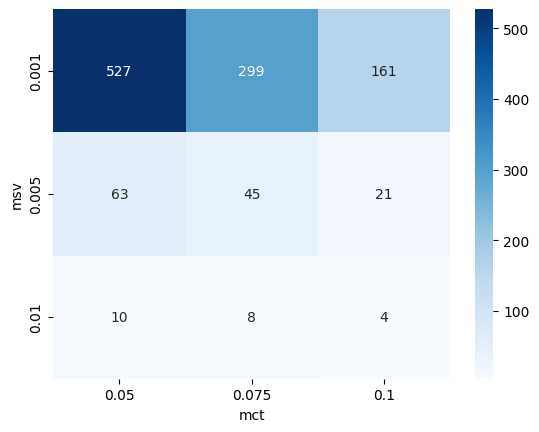

In [8]:
support_vals=[0.001,0.005,0.01]
confidence_vals=[0.05,0.075,0.1]
data=[]
for s in support_vals:
    row=[]
    f=apriori(transactions,s)
    for c in confidence_vals:
        r=rules_from_freq(f,c)
        row.append(len(r))
    data.append(row)

heatmap_df=pd.DataFrame(data,index=support_vals,columns=confidence_vals)
print(heatmap_df)

sns.heatmap(heatmap_df,annot=True,fmt="d",cmap="Blues")
plt.xlabel("mct")
plt.ylabel("msv")
plt.show()

#2 Image Classification using CNN

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np

img_size = (64, 64)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen_raw = datagen.flow_from_directory(
    r"C:/Users/sagar/OneDrive/Desktop/dataset.dm/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_gen_raw = datagen.flow_from_directory(
    r"C:/Users/sagar/OneDrive/Desktop/dataset.dm/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)


Found 3000 images belonging to 3 classes.
Found 582 images belonging to 3 classes.


In [18]:
X_train, y_train = [], []
for i in range(len(train_gen_raw)):
    x, y = train_gen_raw[i]
    X_train.append(x)
    y_train.append(y)
    if (i+1)*batch_size >= train_gen_raw.n:
        break
X_test, y_test = [], []
for i in range(len(test_gen_raw)):
    x, y = test_gen_raw[i]
    X_test.append(x)
    y_test.append(y)
    if (i+1)*batch_size >= test_gen_raw.n:
        break
X = np.concatenate([np.concatenate(X_train), np.concatenate(X_test)])
y = np.concatenate([np.concatenate(y_train), np.concatenate(y_test)])
print("Total merged images:", X.shape, y.shape)

Total merged images: (3582, 64, 64, 3) (3582, 3)


In [19]:
np.random.seed(42)
num_samples = X.shape[0]
indices = np.random.permutation(num_samples)
split = int(0.8 * num_samples)
train_idx = indices[:split]
val_idx = indices[split:]
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]
print("Train set:", X_train.shape, y_train.shape)
print("Val set:", X_val.shape, y_val.shape)


Train set: (2865, 64, 64, 3) (2865, 3)
Val set: (717, 64, 64, 3) (717, 3)


In [20]:
def build_cnn(filter2_size=(3,3), filters2=4, hidden_units=8):
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3,3), activation='relu',
                            input_shape=(img_size[0], img_size[1], 3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(filters2, filter2_size, activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hidden_units, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
base_model = build_cnn()
base_model.summary()


C:\Users\sagar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 4)           │             292 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,823 (26.65 KB)

 Trainable params: 6,823 (26.65 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs = 20  
history_base = base_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5546 - loss: 0.9493 - val_accuracy: 0.6290 - val_loss: 0.7148
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7225 - loss: 0.6645 - val_accuracy: 0.7559 - val_loss: 0.5581
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7627 - loss: 0.5814 - val_accuracy: 0.7615 - val_loss: 0.5243
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7832 - loss: 0.5538 - val_accuracy: 0.7936 - val_loss: 0.4895
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7958 - loss: 0.5126 - val_accuracy: 0.7741 - val_loss: 0.5167
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8035 - loss: 0.5082 - val_accuracy: 0.8075 - val_loss: 0.4574
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8171 - loss: 0.4664 - val_accuracy: 0.8173 - val_loss: 0.4429
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8192 - loss: 0.4543 - val_accuracy: 0.8187 - val

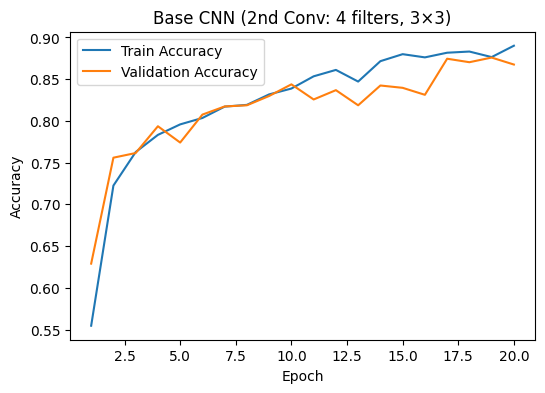

In [22]:
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(1, len(acc) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs_range, acc, label="Train Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
plot_history(history_base, "Base CNN (2nd Conv: 4 filters, 3×3)")


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5609 - loss: 0.9101 - val_accuracy: 0.6485 - val_loss: 0.7999
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6771 - loss: 0.7323 - val_accuracy: 0.7099 - val_loss: 0.6526
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7173 - loss: 0.6710 - val_accuracy: 0.7378 - val_loss: 0.6023
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7770 - loss: 0.5646 - val_accuracy: 0.7378 - val_loss: 0.5867
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7860 - loss: 0.5345 - val_accuracy: 0.8061 - val_loss: 0.4937
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8031 - loss: 0.4885 - val_accuracy: 0.7671 - val_loss: 0.5434
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8307 - loss: 0.4408 - val_accuracy: 0.8382 - val_loss: 0.4312
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8314 - loss: 0.4240 - val_accuracy: 0.8173 - v

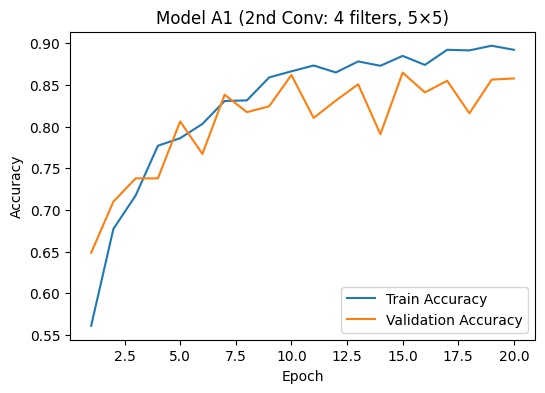

In [23]:
model_a1 = build_cnn(filter2_size=(5,5), filters2=4, hidden_units=8)
history_a1 = model_a1.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_val, y_val)
)
plot_history(history_a1, "Model A1 (2nd Conv: 4 filters, 5×5)")


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5323 - loss: 0.8912 - val_accuracy: 0.5844 - val_loss: 0.7391
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6178 - loss: 0.7679 - val_accuracy: 0.6778 - val_loss: 0.6873
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6778 - loss: 0.7154 - val_accuracy: 0.6862 - val_loss: 0.6651
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7211 - loss: 0.6833 - val_accuracy: 0.7113 - val_loss: 0.6411
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7487 - loss: 0.6310 - val_accuracy: 0.7782 - val_loss: 0.5603
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7682 - loss: 0.5623 - val_accuracy: 0.7894 - val_loss: 0.5078
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8182 - loss: 0.4840 - val_accuracy: 0.7950 - val_loss: 0.4973
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8328 - loss: 0.4388 - val_accuracy: 0.7964 - v

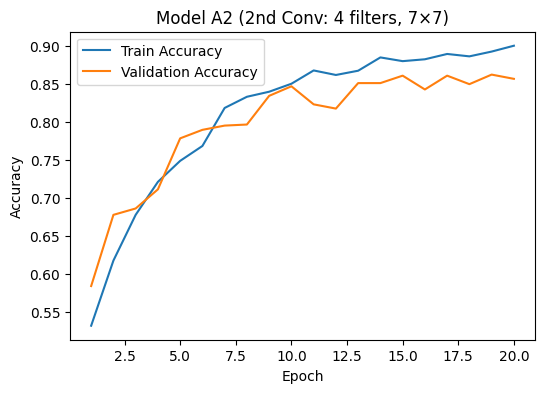

In [24]:
model_a2 = build_cnn(filter2_size=(7,7), filters2=4, hidden_units=8)
history_a2 = model_a2.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_val, y_val)
)
plot_history(history_a2, "Model A2 (2nd Conv: 4 filters, 7×7)")


Q)Describe and discuss what you observe by comparing the performance of the first model and the
other two models you constructed in (a), (b) or (c) (depending on which one you did). Comment
on whether the models are overfit, underfit, or just right. (1 point)
The CNN that has 3x3 filters at its base is the best in generalization.
When the filter size is increased to 5x5 (Model A1) the validation performance does not significantly improve though the training accuracy is marginally higher due to slight overfitting.
The 7x7 (Model A2) version fits better with the best training accuracy and lowest validation accuracy.
Thus, the base model is just right, A1 model is overfitted, and the A2 model is evidently overfitted.

